This notebook tries to identify images of polyps in intestine that can help in early detection of colorectal cancer


Dataset link: https://paperswithcode.com/dataset/medico-automatic-polyp-segmentation-challenge#:~:text=Automatic%20Polyp%20Segmentation-,The%20“Medico%20automatic%20polyp%20segmentation%20challenge”%20aims%20to%20develop%20computer,with%20high%20efficiency%20and%20accuracy.
Download dataset from here https://datasets.simula.no/kvasir-seg/ to the ./data folder and replace the path while instantiating dataset 

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        # List all image and mask files
        self.image_files = sorted([f for f in os.listdir(os.path.join(root_dir, 'images')) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(os.path.join(root_dir, 'masks')) if f.endswith('.jpg')])

        # Split dataset into train and test
        if self.train:
            self.image_files = self.image_files[:800]
            self.mask_files = self.mask_files[:800]
        else:
            self.image_files = self.image_files[800:]
            self.mask_files = self.mask_files[800:]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.root_dir, 'images', self.image_files[idx])
        mask_path = os.path.join(self.root_dir, 'masks', self.mask_files[idx])
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Preprocess the mask
        mask = self.process_mask(mask)

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return {'image': image, 'mask': mask}

    def process_mask(self, mask):
        # Convert mask values as per your requirement
        mask[mask <= 8] = 0
        mask[mask >= 246] = 255
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        return mask

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

train_dataset = CustomDataset(root_dir='/root/GATech/cs7643/polyps_detection/data/Kvasir-SEG', transform=transform, train=True)
val_dataset = CustomDataset(root_dir='/root/GATech/cs7643/polyps_detection/data/Kvasir-SEG', transform=transform, train=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

/usr/local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


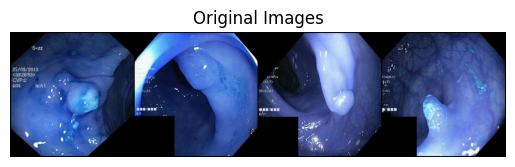

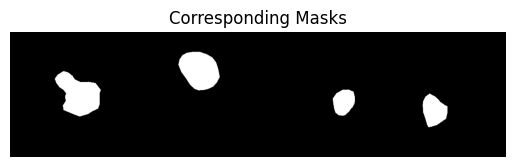

In [3]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF

def reverse_transform(tensor):
    """Converts a PyTorch tensor to a NumPy array for visualization."""
    image = tensor.cpu().clone()
    image = image.squeeze(0)  # Remove batch dimension
    image = TF.to_pil_image(image)
    return np.array(image)

# Visualize some random samples from the test dataset
num_samples = 4

for batch in val_loader:
    images, masks = batch['image'], batch['mask']
    break  # Break after the first batch

# Visualize original images
grid_images = make_grid(images[:num_samples], nrow=num_samples)
plt.imshow(reverse_transform(grid_images))
plt.title('Original Images')
plt.axis('off')
plt.show()

# Visualize corresponding masks
grid_masks = make_grid(masks[:num_samples], nrow=num_samples)
plt.imshow(reverse_transform(grid_masks), cmap='gray')
plt.title('Corresponding Masks')
plt.axis('off')
plt.show()


In [4]:
len(train_loader)

50

In [7]:
# Check for CUDA availability
from unet import UNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)

# Initialize the model
model = UNet(3, 1, [64, 128, 256, 512])

# Move the model to the CUDA device if available
model = model.to(device)

epochs = 30
lr = 0.001
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Using device: cuda


In [24]:
def pixel_acc(outputs, mask):
    outputs = (outputs > 0.5).float()  # Convert probability to binary prediction
    correct_pixels = torch.eq(outputs, mask).float().sum()
    total_pixels = mask.numel()
    accuracy = correct_pixels / total_pixels
    return accuracy

def calculate_iou(outputs, mask):
    outputs = (outputs > 0.5).float()
    intersection = torch.logical_and(outputs, mask).sum()
    union = torch.logical_or(outputs, mask).sum()
    iou = intersection / union if union != 0 else 0.0
    return iou

def dice_index(outputs, mask):
    smooth = 1e-5
    outputs = (outputs > 0.5).float()
    intersection = torch.sum(outputs * mask)
    union = torch.sum(outputs) + torch.sum(mask)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

EPOCH 0:


Training Loop, Epoch: 0: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.7222541069984436, Training accuracy: 0.9407258629798889, DICE:0.8036387920379638 ,IOU: 0.6744399070739746


Validation Loop, Epoch: 0:   0%|          | 0/13 [00:00<?, ?it/s]

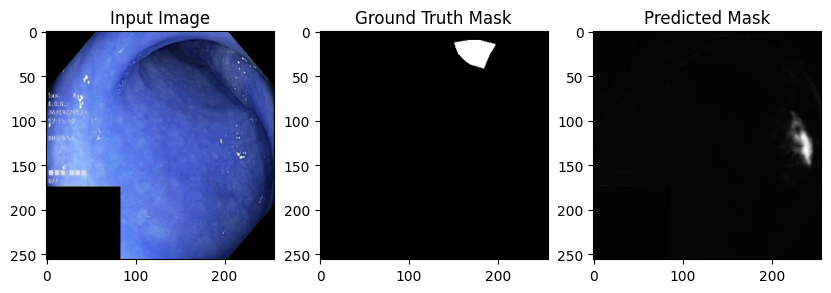

Validation Loop, Epoch: 0: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Validation loss: 0.7189783499791071, Validation accuracy: 0.92377769947052,DICE:0.7521875500679016,IOU: 0.6090772151947021
EPOCH 1:


Training Loop, Epoch: 1: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.718102822303772, Training accuracy: 0.9442949295043945, DICE:0.81637739777565 ,IOU: 0.6937116980552673


Validation Loop, Epoch: 1:   0%|          | 0/13 [00:00<?, ?it/s]

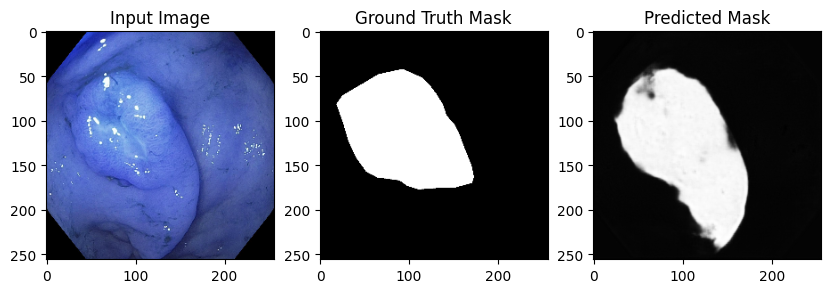

Validation Loop, Epoch: 1: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.7147382818735563, Validation accuracy: 0.9187661409378052,DICE:0.719573988364293,IOU: 0.5660325884819031
EPOCH 2:


Training Loop, Epoch: 2: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.714999293088913, Training accuracy: 0.945577085018158, DICE:0.8210148465633392 ,IOU: 0.7000252604484558


Validation Loop, Epoch: 2:   0%|          | 0/13 [00:00<?, ?it/s]

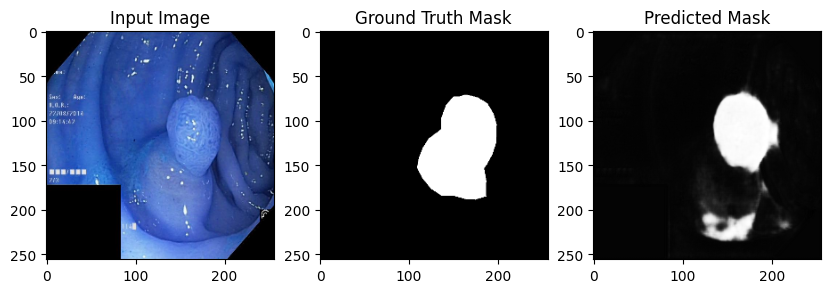

Validation Loop, Epoch: 2: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.7128332119721633, Validation accuracy: 0.909669041633606,DICE:0.6820062765708337,IOU: 0.5230403542518616
EPOCH 3:


Training Loop, Epoch: 3: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.7123443615436554, Training accuracy: 0.9467718005180359, DICE:0.822481300830841 ,IOU: 0.701454222202301


Validation Loop, Epoch: 3:   0%|          | 0/13 [00:00<?, ?it/s]

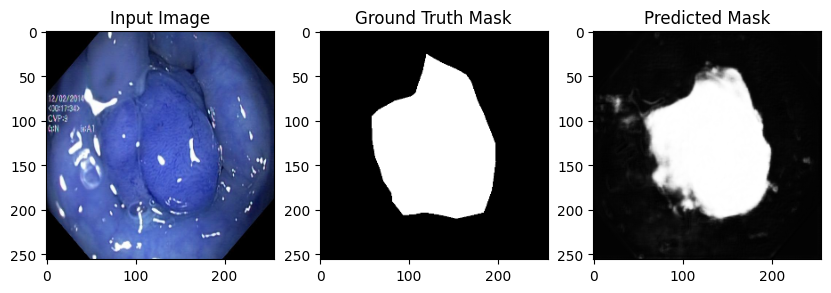

Validation Loop, Epoch: 3: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.712302565574646, Validation accuracy: 0.9212855696678162,DICE:0.7387550152265109,IOU: 0.5909369587898254
EPOCH 4:


Training Loop, Epoch: 4: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.7090437984466553, Training accuracy: 0.9490867257118225, DICE:0.8316124713420868 ,IOU: 0.7148023247718811


Validation Loop, Epoch: 4:   0%|          | 0/13 [00:00<?, ?it/s]

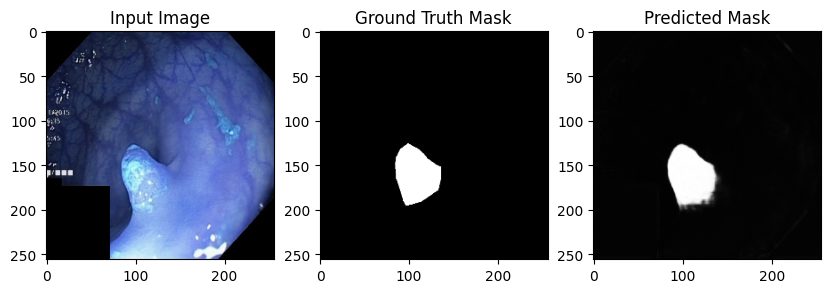

Validation Loop, Epoch: 4: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.7098657901470478, Validation accuracy: 0.9140803813934326,DICE:0.6804937491050134,IOU: 0.5200961232185364
EPOCH 5:


Training Loop, Epoch: 5: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.7068038582801819, Training accuracy: 0.9496488571166992, DICE:0.8307383453845978 ,IOU: 0.713517963886261


Validation Loop, Epoch: 5:   0%|          | 0/13 [00:00<?, ?it/s]

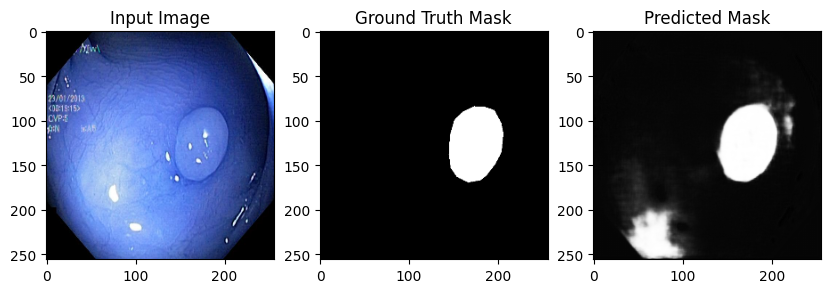

Validation Loop, Epoch: 5: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.7067087751168472, Validation accuracy: 0.9246290326118469,DICE:0.759986909536215,IOU: 0.6153554320335388
EPOCH 6:


Training Loop, Epoch: 6: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.7029125225543976, Training accuracy: 0.9538878202438354, DICE:0.8478307116031647 ,IOU: 0.7384200692176819


Validation Loop, Epoch: 6:   0%|          | 0/13 [00:00<?, ?it/s]

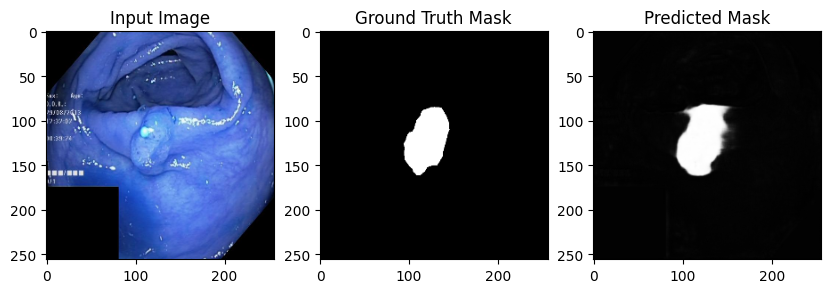

Validation Loop, Epoch: 6: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.7029605920498188, Validation accuracy: 0.9322472214698792,DICE:0.7818989432775058,IOU: 0.6438398361206055
EPOCH 7:


Training Loop, Epoch: 7: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.7006323373317719, Training accuracy: 0.9550762176513672, DICE:0.8514131772518158 ,IOU: 0.7437889575958252


Validation Loop, Epoch: 7:   0%|          | 0/13 [00:00<?, ?it/s]

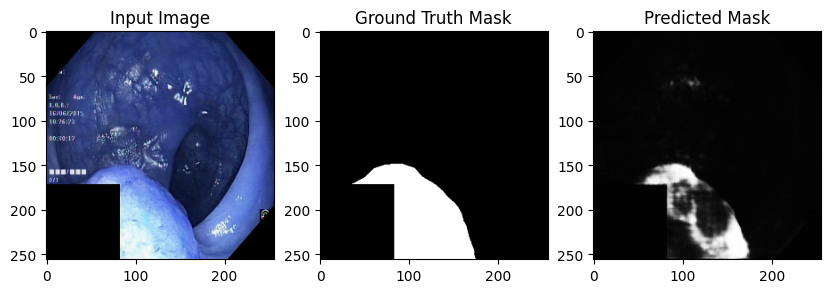

Validation Loop, Epoch: 7: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.7046670317649841, Validation accuracy: 0.9278667569160461,DICE:0.7610431405214163,IOU: 0.620692789554596
EPOCH 8:


Training Loop, Epoch: 8: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6967336189746857, Training accuracy: 0.9596554636955261, DICE:0.8687347543239593 ,IOU: 0.7709536552429199


Validation Loop, Epoch: 8:   0%|          | 0/13 [00:00<?, ?it/s]

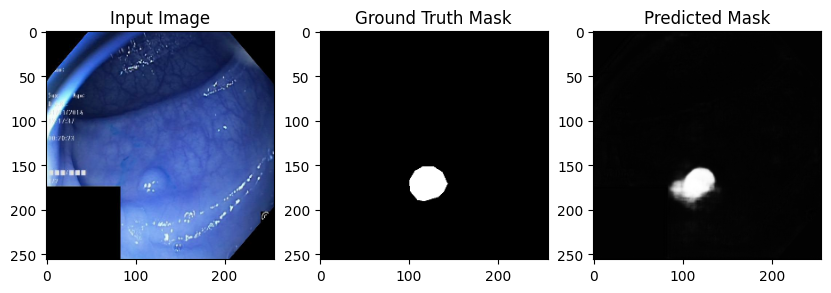

Validation Loop, Epoch: 8: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.7034819997273959, Validation accuracy: 0.927617609500885,DICE:0.7740059724220862,IOU: 0.6385465860366821
EPOCH 9:


Training Loop, Epoch: 9: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6943703114986419, Training accuracy: 0.9611886143684387, DICE:0.874211630821228 ,IOU: 0.7781493067741394


Validation Loop, Epoch: 9:   0%|          | 0/13 [00:00<?, ?it/s]

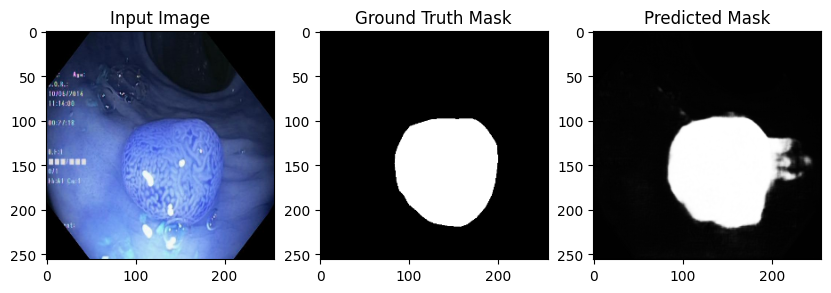

Validation Loop, Epoch: 9: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Validation loss: 0.7005722935383136, Validation accuracy: 0.9286795258522034,DICE:0.7629050016403198,IOU: 0.621850311756134
EPOCH 10:


Training Loop, Epoch: 10: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6936304485797882, Training accuracy: 0.959359347820282, DICE:0.8672844755649567 ,IOU: 0.7679901719093323


Validation Loop, Epoch: 10:   0%|          | 0/13 [00:00<?, ?it/s]

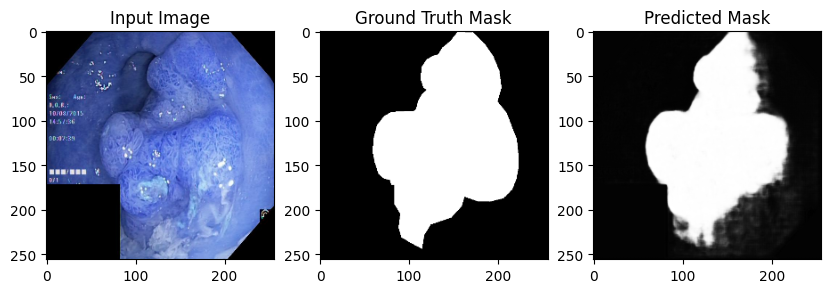

Validation Loop, Epoch: 10: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Validation loss: 0.6974357687509977, Validation accuracy: 0.9267117977142334,DICE:0.7459508088918833,IOU: 0.5969913601875305
EPOCH 11:


Training Loop, Epoch: 11: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Training loss: 0.6908954083919525, Training accuracy: 0.9618998765945435, DICE:0.8750114703178405 ,IOU: 0.7803849577903748


Validation Loop, Epoch: 11:   0%|          | 0/13 [00:00<?, ?it/s]

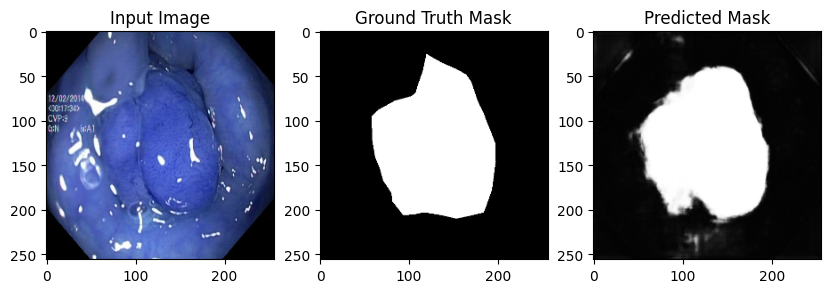

Validation Loop, Epoch: 11: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.711243042579064, Validation accuracy: 0.9118685126304626,DICE:0.7526828784209031,IOU: 0.606824517250061
EPOCH 12:


Training Loop, Epoch: 12: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Training loss: 0.6887716424465179, Training accuracy: 0.9634711742401123, DICE:0.878950513601303 ,IOU: 0.7855770587921143


Validation Loop, Epoch: 12:   0%|          | 0/13 [00:00<?, ?it/s]

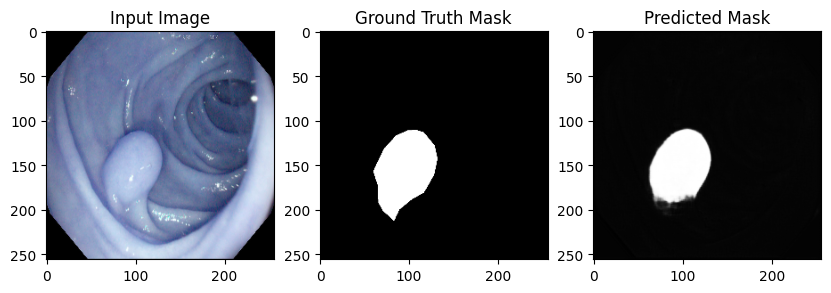

Validation Loop, Epoch: 12: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Validation loss: 0.6940073233384353, Validation accuracy: 0.9237862825393677,DICE:0.7313968309989343,IOU: 0.5867972373962402
EPOCH 13:


Training Loop, Epoch: 13: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6860654544830322, Training accuracy: 0.966315746307373, DICE:0.8905391275882721 ,IOU: 0.8046877980232239


Validation Loop, Epoch: 13:   0%|          | 0/13 [00:00<?, ?it/s]

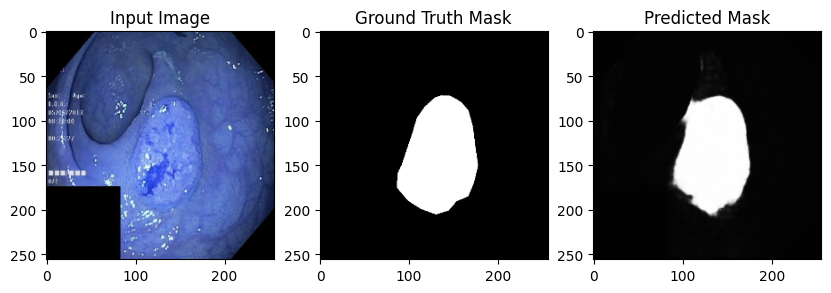

Validation Loop, Epoch: 13: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Validation loss: 0.6959766791417048, Validation accuracy: 0.9286450147628784,DICE:0.7828041315078735,IOU: 0.6478582620620728
EPOCH 14:


Training Loop, Epoch: 14: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.684457300901413, Training accuracy: 0.9667755961418152, DICE:0.8921892309188842 ,IOU: 0.8063869476318359


Validation Loop, Epoch: 14:   0%|          | 0/13 [00:00<?, ?it/s]

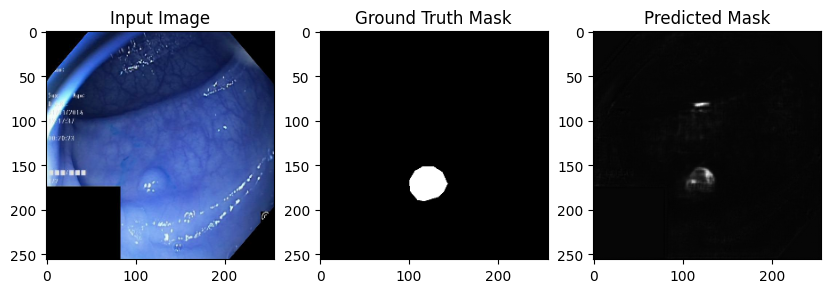

Validation Loop, Epoch: 14: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Validation loss: 0.6894850409947909, Validation accuracy: 0.9312154650688171,DICE:0.7768425299571111,IOU: 0.6403855681419373
EPOCH 15:


Training Loop, Epoch: 15: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6822662651538849, Training accuracy: 0.9690295457839966, DICE:0.8991417181491852 ,IOU: 0.8186837434768677


Validation Loop, Epoch: 15:   0%|          | 0/13 [00:00<?, ?it/s]

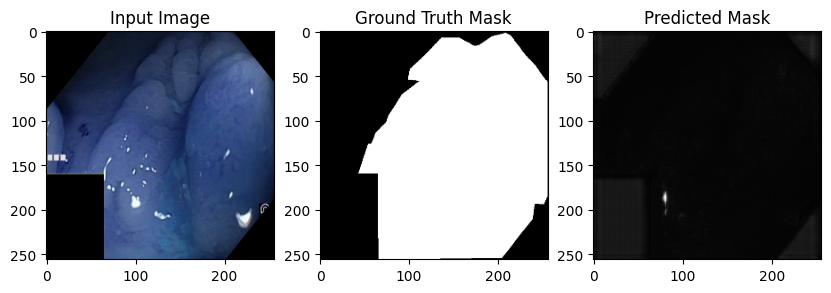

Validation Loop, Epoch: 15: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Validation loss: 0.6949564401920025, Validation accuracy: 0.9312119483947754,DICE:0.7790921101203332,IOU: 0.6410486698150635
EPOCH 16:


Training Loop, Epoch: 16: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.681808911561966, Training accuracy: 0.9674496054649353, DICE:0.8933072280883789 ,IOU: 0.8088482618331909


Validation Loop, Epoch: 16:   0%|          | 0/13 [00:00<?, ?it/s]

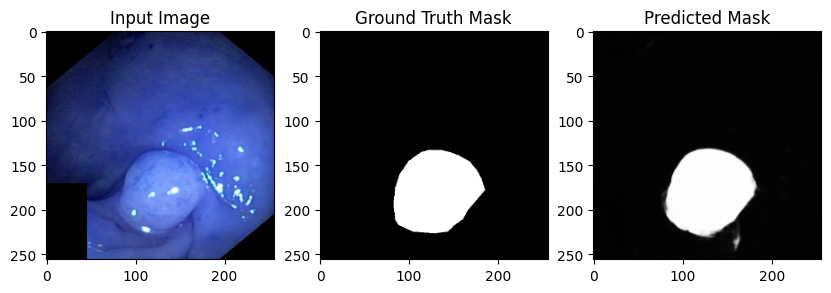

Validation Loop, Epoch: 16: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Validation loss: 0.689182671216818, Validation accuracy: 0.9327199459075928,DICE:0.7816028824219337,IOU: 0.6459559202194214
EPOCH 17:


Training Loop, Epoch: 17: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.680057921409607, Training accuracy: 0.9688484072685242, DICE:0.8995388758182525 ,IOU: 0.8187845349311829


Validation Loop, Epoch: 17:   0%|          | 0/13 [00:00<?, ?it/s]

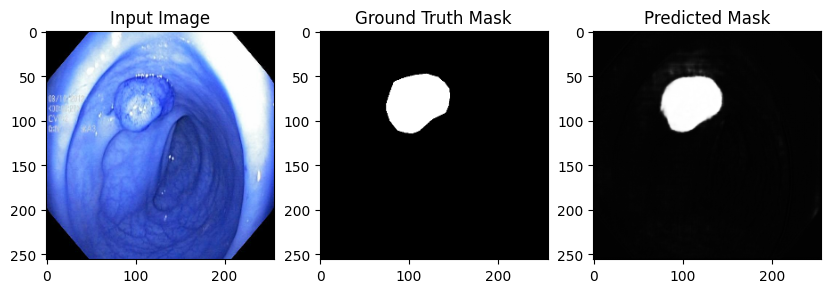

Validation Loop, Epoch: 17: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.689264022386991, Validation accuracy: 0.9296971559524536,DICE:0.7773664822945228,IOU: 0.6389053463935852
EPOCH 18:


Training Loop, Epoch: 18: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6786861312389374, Training accuracy: 0.9694159626960754, DICE:0.901641628742218 ,IOU: 0.8223341703414917


Validation Loop, Epoch: 18:   0%|          | 0/13 [00:00<?, ?it/s]

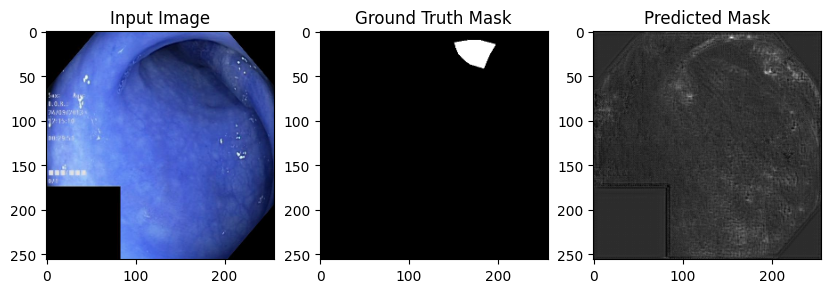

Validation Loop, Epoch: 18: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.6874644756317139, Validation accuracy: 0.9293738603591919,DICE:0.7723598250975976,IOU: 0.6344980597496033
EPOCH 19:


Training Loop, Epoch: 19: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.675387110710144, Training accuracy: 0.9743359684944153, DICE:0.9183896541595459 ,IOU: 0.8496198058128357


Validation Loop, Epoch: 19:   0%|          | 0/13 [00:00<?, ?it/s]

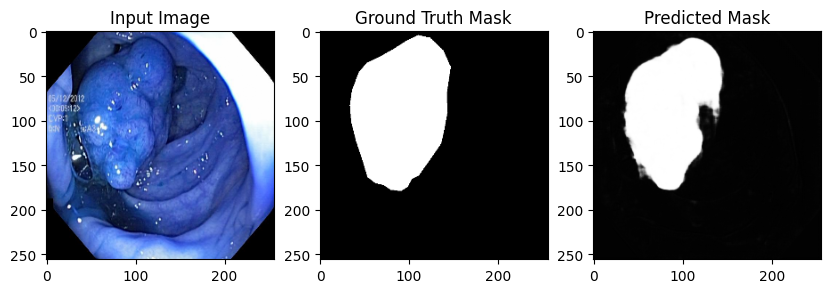

Validation Loop, Epoch: 19: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


Validation loss: 0.6843215318826529, Validation accuracy: 0.9353604912757874,DICE:0.7946892289014963,IOU: 0.6617878079414368
EPOCH 20:


Training Loop, Epoch: 20: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6736046350002289, Training accuracy: 0.9761200547218323, DICE:0.9250277352333068 ,IOU: 0.8608328104019165


Validation Loop, Epoch: 20:   0%|          | 0/13 [00:00<?, ?it/s]

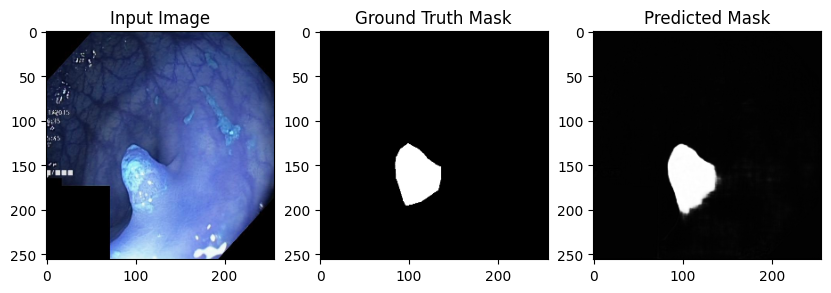

Validation Loop, Epoch: 20: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.6826898776567899, Validation accuracy: 0.9339252710342407,DICE:0.7900724502710196,IOU: 0.6550207138061523
EPOCH 21:


Training Loop, Epoch: 21: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6725633203983307, Training accuracy: 0.9762287139892578, DICE:0.9249299967288971 ,IOU: 0.8608150482177734


Validation Loop, Epoch: 21:   0%|          | 0/13 [00:00<?, ?it/s]

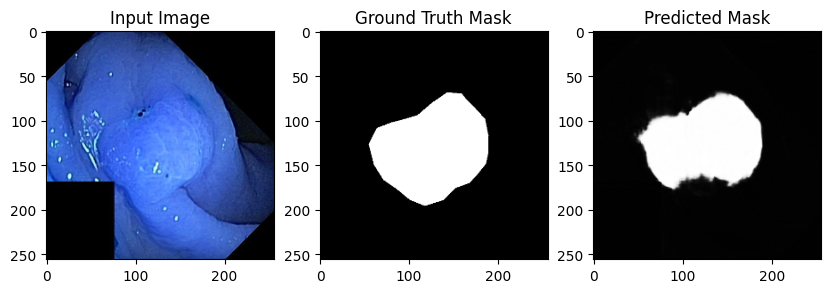

Validation Loop, Epoch: 21: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Validation loss: 0.6843117062862103, Validation accuracy: 0.9348475933074951,DICE:0.7994485451624944,IOU: 0.6683982014656067
EPOCH 22:


Training Loop, Epoch: 22: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6717445075511932, Training accuracy: 0.9759681224822998, DICE:0.9248186504840851 ,IOU: 0.8603180646896362


Validation Loop, Epoch: 22:   0%|          | 0/13 [00:00<?, ?it/s]

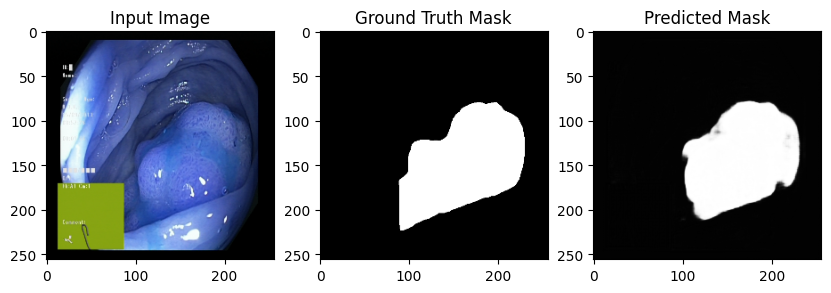

Validation Loop, Epoch: 22: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.6819174014605008, Validation accuracy: 0.9253448247909546,DICE:0.7495029339423547,IOU: 0.6019054055213928
EPOCH 23:


Training Loop, Epoch: 23: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6699037837982178, Training accuracy: 0.9782898426055908, DICE:0.9318920171260834 ,IOU: 0.8722918033599854


Validation Loop, Epoch: 23:   0%|          | 0/13 [00:00<?, ?it/s]

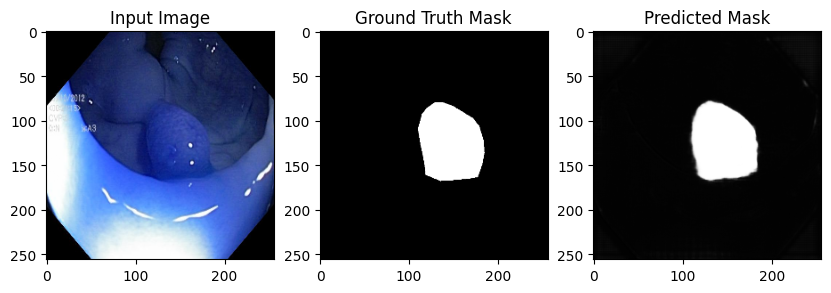

Validation Loop, Epoch: 23: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Validation loss: 0.6850158755595868, Validation accuracy: 0.9246958494186401,DICE:0.7346743528659527,IOU: 0.5855980515480042
EPOCH 24:


Training Loop, Epoch: 24: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Training loss: 0.6687344896793366, Training accuracy: 0.9788409471511841, DICE:0.9338391649723053 ,IOU: 0.8758090734481812


Validation Loop, Epoch: 24:   0%|          | 0/13 [00:00<?, ?it/s]

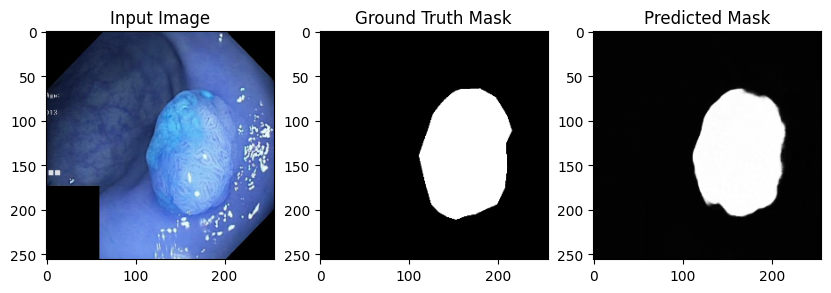

Validation Loop, Epoch: 24: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.6854563447145315, Validation accuracy: 0.9318004250526428,DICE:0.7966091128496023,IOU: 0.6681819558143616
EPOCH 25:


Training Loop, Epoch: 25: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Training loss: 0.6676531195640564, Training accuracy: 0.9795410633087158, DICE:0.9362253284454346 ,IOU: 0.8799155354499817


Validation Loop, Epoch: 25:   0%|          | 0/13 [00:00<?, ?it/s]

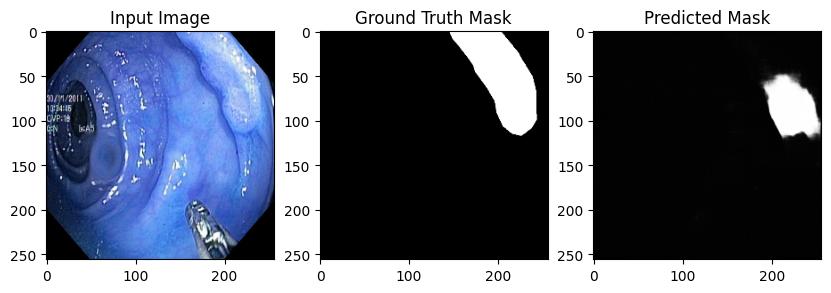

Validation Loop, Epoch: 25: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Validation loss: 0.6770718968831576, Validation accuracy: 0.9357193112373352,DICE:0.8000694925968463,IOU: 0.6685539484024048
EPOCH 26:


Training Loop, Epoch: 26: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6682350707054138, Training accuracy: 0.976750910282135, DICE:0.9253589117527008 ,IOU: 0.8615437746047974


Validation Loop, Epoch: 26:   0%|          | 0/13 [00:00<?, ?it/s]

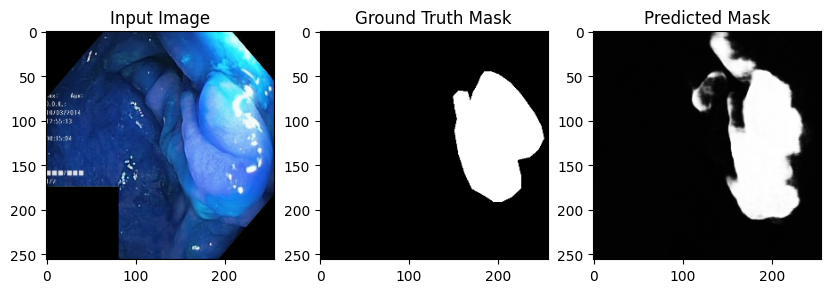

Validation Loop, Epoch: 26: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation loss: 0.6770348594738886, Validation accuracy: 0.9313734769821167,DICE:0.7767795874522283,IOU: 0.6367536783218384
EPOCH 27:


Training Loop, Epoch: 27: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6663198924064636, Training accuracy: 0.979292094707489, DICE:0.935721127986908 ,IOU: 0.8788629770278931


Validation Loop, Epoch: 27:   0%|          | 0/13 [00:00<?, ?it/s]

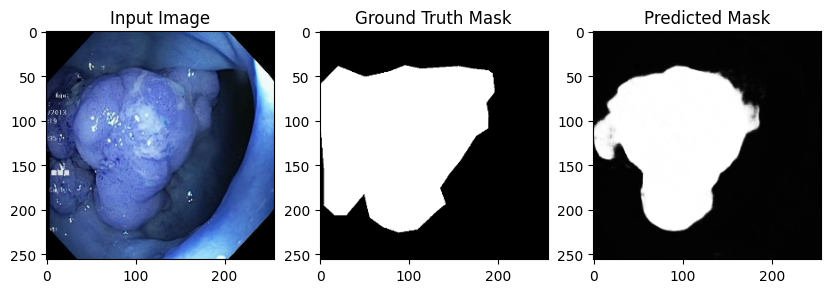

Validation Loop, Epoch: 27: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Validation loss: 0.6784118551474351, Validation accuracy: 0.9345697164535522,DICE:0.7940489924871005,IOU: 0.6613120436668396
EPOCH 28:


Training Loop, Epoch: 28: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Training loss: 0.6650808334350586, Training accuracy: 0.9805145263671875, DICE:0.9402775287628173 ,IOU: 0.887039303779602


Validation Loop, Epoch: 28:   0%|          | 0/13 [00:00<?, ?it/s]

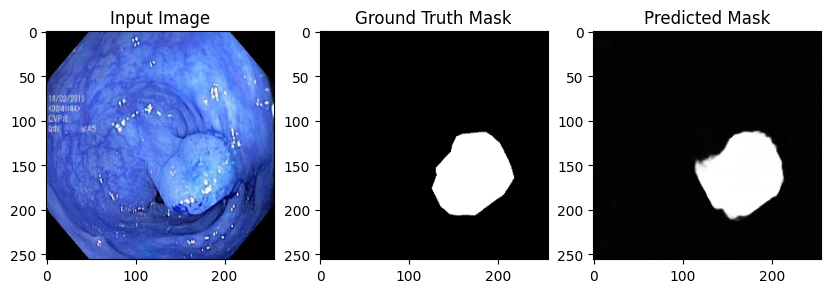

Validation Loop, Epoch: 28: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Validation loss: 0.679127587721898, Validation accuracy: 0.9291040301322937,DICE:0.7707293858894935,IOU: 0.629673957824707
EPOCH 29:


Training Loop, Epoch: 29: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Training loss: 0.6658276510238648, Training accuracy: 0.9773901104927063, DICE:0.9296713304519654 ,IOU: 0.8686468601226807


Validation Loop, Epoch: 29:   0%|          | 0/13 [00:00<?, ?it/s]

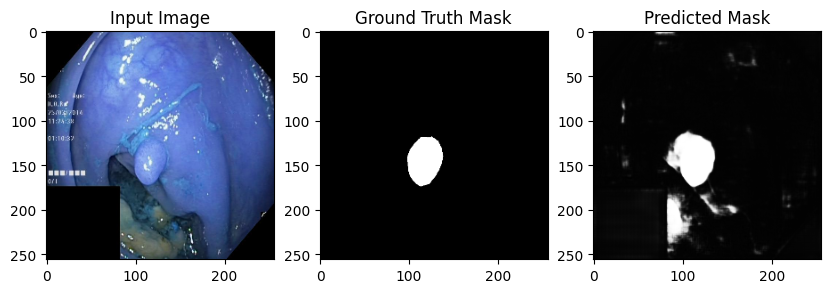

Validation Loop, Epoch: 29: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

Validation loss: 0.6818402638802161, Validation accuracy: 0.9279736280441284,DICE:0.7764155268669128,IOU: 0.6364405751228333


In [25]:

# Training and validation code
for epoch in range(epochs):
    print(f"EPOCH {epoch}:")
    model.train()
    batch_loss = batch_acc = batch_iou=batch_pacc=0.0

    for batch in tqdm(train_loader, desc=f"Training Loop, Epoch: {epoch}"):
        # Move data to CUDA
        img, mask = batch['image'], batch['mask']
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        outs = model(img)
        # loss=dice_loss(outs, mask)
        loss=criterion(outs,mask)
        # loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            accuracy = dice_index(outs, mask)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            batch_loss += loss.item()
            batch_acc += accuracy.item()
            batch_iou+=iou
            batch_pacc+=pacc

    batch_loss /= len(train_loader)
    batch_acc /= len(train_loader)
    batch_iou/=len(train_loader)
    batch_pacc/=len(train_loader)
    print(f"Training loss: {batch_loss}, Training accuracy: {batch_pacc}, DICE:{batch_acc} ,IOU: {batch_iou}")
    model.eval()
    val_loss = val_acc = val_iou=val_pacc=0.0

    with torch.no_grad():
        sample_printed = False
        for batch in tqdm(val_loader, desc=f"Validation Loop, Epoch: {epoch}"):
            # Move data to CUDA
            img, mask = batch['image'], batch['mask']
            img, mask = img.to(device), mask.to(device)
            
            
            outs = model(img)
            loss=criterion(outs, mask)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            accuracy = dice_index(outs, mask)
            val_loss += loss.item()
            val_acc += accuracy.item()
            val_iou+=iou
            val_pacc+=pacc
            
            if not sample_printed:
                sample_printed = True
                idx = 0  # Choose the index of the sample to print
                sample_img = img[idx].cpu().numpy().transpose((1, 2, 0))
                sample_mask = mask[idx].cpu().numpy()
                sample_pred = outs[idx].cpu().numpy()

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(sample_img)
                plt.title("Input Image")

                plt.subplot(1, 3, 2)

                # Check if the mask is 2D or 3D
                if sample_mask.ndim == 3 and sample_mask.shape[0] == 1:
                    sample_mask = sample_mask[0]  # Remove the singleton dimension

                plt.imshow(sample_mask, cmap='gray')
                plt.title("Ground Truth Mask")

                plt.subplot(1, 3, 3)

                # Check if the prediction is 2D or 3D
                if sample_pred.ndim == 3 and sample_pred.shape[0] == 1:
                    sample_pred = sample_pred[0]  # Remove the singleton dimension

                plt.imshow(sample_pred, cmap='gray')
                plt.title("Predicted Mask")

                plt.show()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_iou/=len(val_loader)
    val_pacc/=len(val_loader)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_pacc},DICE:{val_acc},IOU: {val_iou}")

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print(f"Number of parameters in the U-Net model: {num_params}")

Number of parameters in the U-Net model: 18812674
